In [1]:
from sklearn.linear_model import LinearRegression
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from itertools import repeat

import numpy as np
import pandas as pd

In [2]:
main_data_path = "C:/Users/ASUS X751L/Desktop/5_WindSolar_Daily_Power_Production.csv"

In [3]:
main_data = pd.read_csv(main_data_path)

In [4]:
main_data

,Date and Hour,StartHour,EndHour,Source,Production
0,2020-07-22 20:00:00+02:00,20:00:00,21:00:00,Solar,244.0 MWh
1,2020-07-23 07:00:00+02:00,7:00:00,8:00:00,Solar,223.0 MWh
2,2020-07-23 16:00:00+02:00,16:00:00,17:00:00,Solar,2517.0 MWh
3,2020-07-23 19:00:00+02:00,19:00:00,20:00:00,Solar,658.0 MWh
4,2020-07-23 23:00:00+02:00,23:00:00,24:00:00,Solar,0.0 MWh
...,...,...,...,...,...
59801,2023-06-30 06:00:00+02:00,6:00:00,7:00:00,Solar,55.0 MWh
59802,2023-06-30 13:00:00+02:00,13:00:00,14:00:00,Solar,4554.0 MWh
59803,2023-06-30 14:00:00+02:00,14:00:00,15:00:00,Solar,4589.0 MWh
59804,2023-06-30 16:00:00+02:00,16:00:00,17:00:00,Solar,4173.0 MWh


In [5]:
main_data["Date and Hour"] = main_data["Date and Hour"].str.slice(stop=-15)


In [6]:
main_data["Date and Hour"]=pd.to_datetime(main_data["Date and Hour"])

In [7]:
#вычленяем из столбца с датой-год, месяц
main_data
main_data["Year"] = main_data["Date and Hour"].dt.year
main_data["Month"]=main_data["Date and Hour"].dt.month
#main_data["Day"]=main_data["Date and Hour"].dt.day
#main_data["Day_Of_Year"]=main_data["Date and Hour"].dt.dayofyear
#main_data["Week_Day"]=main_data["Date and Hour"].dt.weekday

In [8]:
#обрезаю лишние символы из столбца с началом и концом работы, чтобы потом преобразовать к интам
main_data["StartHour"] = main_data["StartHour"].str.slice(stop=-6)
main_data["EndHour"] = main_data["EndHour"].str.slice(stop=-6)

In [9]:
#привожу к интам начало и конец работы
main_data["StartHour"] = main_data["StartHour"].astype (str).astype (int)
main_data["EndHour"] = main_data["EndHour"].astype (str).astype (int)

In [10]:
#заменяю солнце, ветер на 1/0
main_data["Source"]=main_data["Source"].replace("Wind",0)
main_data["Source"]=main_data["Source"].replace("Solar",1)

In [11]:
def remove_mwh(stroka:str):
    stroka=str(stroka)
    if stroka.find("MWh")!=1:
        stroka=stroka.replace("MWh","")

    return float(stroka)

In [12]:
main_data["Production"]=main_data["Production"].apply(remove_mwh)

In [13]:
#нашли Nan
df=main_data[pd.isnull(main_data["Production"])]
df

,Date and Hour,StartHour,EndHour,Source,Production,Year,Month
36164,2022-03-27,2,3,1,NaN,2022,3
39321,2022-03-27,2,3,0,NaN,2022,3


In [14]:
#заменяем nan на нули
main_data["Production"] = main_data["Production"]. fillna (0)
main_data.rename(columns={'Date and Hour': 'Date'}, inplace=True)
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        59806 non-null  datetime64[ns]
 1   StartHour   59806 non-null  int32         
 2   EndHour     59806 non-null  int32         
 3   Source      59806 non-null  int64         
 4   Production  59806 non-null  float64       
 5   Year        59806 non-null  int32         
 6   Month       59806 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1)
memory usage: 2.3 MB


In [15]:
main_data

,Date,StartHour,EndHour,Source,Production,Year,Month
0,2020-07-22,20,21,1,244.0,2020,7
1,2020-07-23,7,8,1,223.0,2020,7
2,2020-07-23,16,17,1,2517.0,2020,7
3,2020-07-23,19,20,1,658.0,2020,7
4,2020-07-23,23,24,1,0.0,2020,7
...,...,...,...,...,...,...,...
59801,2023-06-30,6,7,1,55.0,2023,6
59802,2023-06-30,13,14,1,4554.0,2023,6
59803,2023-06-30,14,15,1,4589.0,2023,6
59804,2023-06-30,16,17,1,4173.0,2023,6


In [16]:
#сортируем даты в порядке возрастания
main_data=main_data.sort_values(by='Date')
main_data

,Date,StartHour,EndHour,Source,Production,Year,Month
1475,2020-01-01,7,8,1,0.0,2020,1
124,2020-01-01,23,24,0,1184.0,2020,1
122,2020-01-01,16,17,0,853.0,2020,1
120,2020-01-01,15,16,0,763.0,2020,1
118,2020-01-01,7,8,0,2064.0,2020,1
...,...,...,...,...,...,...,...
58941,2023-06-30,13,14,0,3851.0,2023,6
58942,2023-06-30,10,11,0,2188.0,2023,6
58943,2023-06-30,15,16,0,5142.0,2023,6
59378,2023-06-30,7,8,0,2223.0,2023,6


In [17]:
main_data["Source"].value_counts()

Source
0    29904
1    29902
Name: count, dtype: int64

In [18]:
main_data.groupby(["Source"])["Production"].sum()

Source
0    135064132.0
1     31960054.0
Name: Production, dtype: float64

In [19]:
main_data.groupby(["Year","Source"])["Production"].sum()

Year  Source
2020  0         35372922.0
      1          6389965.0
2021  0         36423417.0
      1          8323800.0
2022  0         38562065.0
      1         10939288.0
2023  0         24705728.0
      1          6307001.0
Name: Production, dtype: float64

In [20]:
main_data.groupby(["Month", "Source"])["Production"].sum()

Month  Source
1      0         17189200.0
       1          1345917.0
2      0         18746805.0
       1          2093329.0
3      0         12879692.0
       1          2480338.0
4      0         12616388.0
       1          3862842.0
5      0         12345343.0
       1          4570626.0
6      0          7325606.0
       1          4549171.0
7      0          6209485.0
       1          3463424.0
8      0          6278079.0
       1          3162019.0
9      0          6056969.0
       1          2520619.0
10     0         11330429.0
       1          1874316.0
11     0         10707943.0
       1          1207208.0
12     0         13378193.0
       1           830245.0
Name: Production, dtype: float64

In [21]:
production=main_data.groupby(["Date", "Source"])["Production"].sum().reset_index()

solar_data=production[production["Source"]==1]
wind_data=production[production["Source"]==0]


Text(0, 0.5, 'Производительность, MWh')

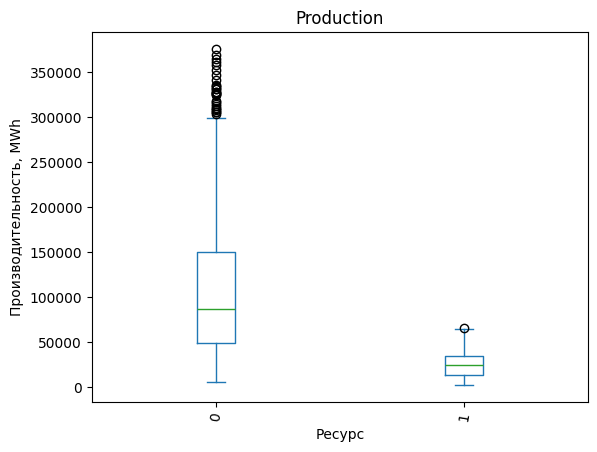

In [22]:
production.plot.box(column="Production",by="Source")
plt.xticks(rotation=80)
plt.xlabel("Ресурс")
plt.ylabel("Производительность, MWh")

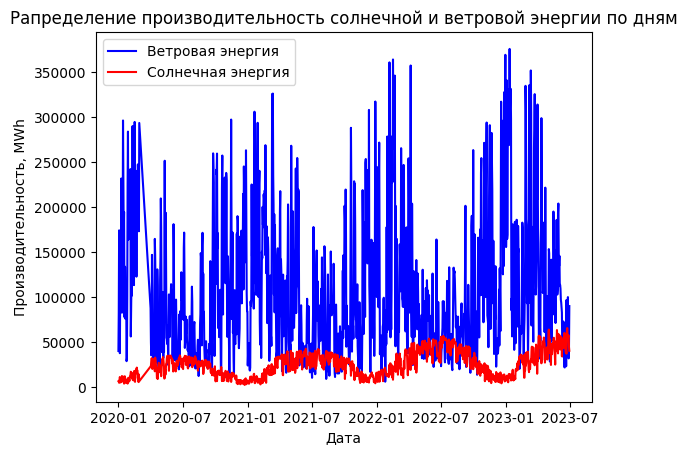

In [23]:
plt.figure
plt.plot(wind_data["Date"], wind_data["Production"],color="blue", label="Ветровая энергия")
plt.plot(solar_data["Date"], solar_data["Production"],color="red", label="Солнечная энергия")
plt.xlabel("Дата")
plt.ylabel("Производительность, MWh")
plt.title("Рапределение производительность солнечной и ветровой энергии по дням")
plt.legend()

In [ ]:
Далее производим группировку одельно по солнечной и по ветровой энергии для дальнейшего анализа

In [24]:
solar_data=solar_data.reset_index(drop=True)
solar_data

,Date,Source,Production
0,2020-01-01,1,6821.0
1,2020-01-02,1,6349.0
2,2020-01-03,1,5036.0
3,2020-01-04,1,7957.0
4,2020-01-05,1,11438.0
...,...,...,...
1241,2023-06-26,1,54698.0
1242,2023-06-27,1,56356.0
1243,2023-06-28,1,57698.0
1244,2023-06-29,1,44728.0


In [25]:
solar_data["Day_Of_Year"]=solar_data["Date"].dt.dayofyear
solar_data["Month"]=solar_data["Date"].dt.month
solar_data 

,Date,Source,Production,Day_Of_Year,Month
0,2020-01-01,1,6821.0,1,1
1,2020-01-02,1,6349.0,2,1
2,2020-01-03,1,5036.0,3,1
3,2020-01-04,1,7957.0,4,1
4,2020-01-05,1,11438.0,5,1
...,...,...,...,...,...
1241,2023-06-26,1,54698.0,177,6
1242,2023-06-27,1,56356.0,178,6
1243,2023-06-28,1,57698.0,179,6
1244,2023-06-29,1,44728.0,180,6


Text(0.5, 1.0, 'Производительность солненой энергии по месяцам')

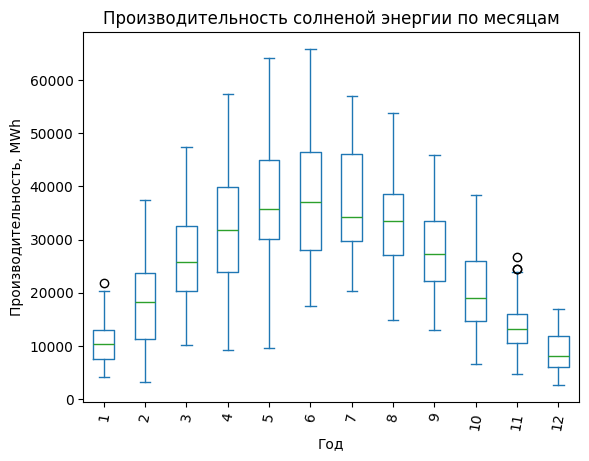

In [26]:
solar_data.plot.box(column="Production", by="Month")
plt.xticks(rotation=80)
plt.xlabel("Год")
plt.ylabel("Производительность, MWh")
plt.title("Производительность солненой энергии по месяцам")

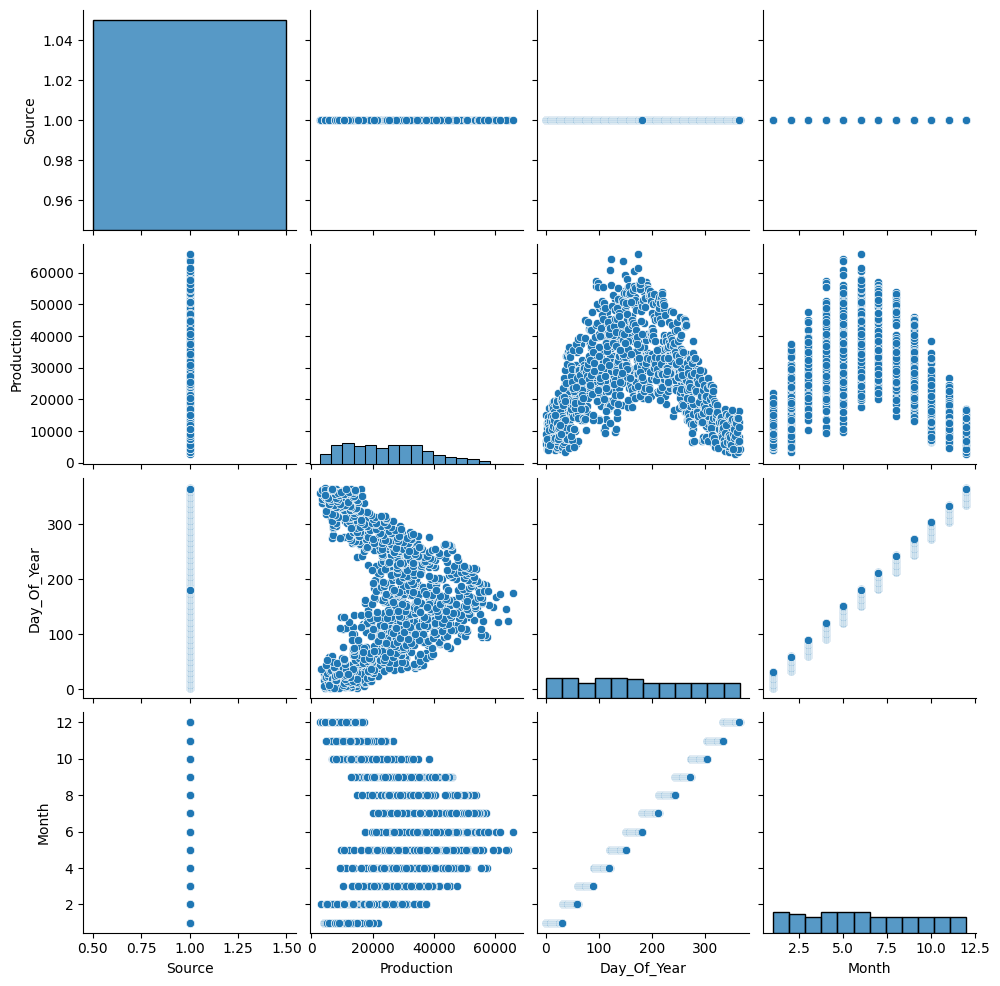

In [27]:
sns.pairplot(solar_data)

In [28]:
dayofyear_solar=solar_data.groupby(["Day_Of_Year","Month"])["Production"].agg(["sum", "count"]).reset_index()
dayofyear_solar

,Day_Of_Year,Month,sum,count
0,1,1,36874.0,4
1,2,1,27008.0,4
2,3,1,35688.0,4
3,4,1,31591.0,4
4,5,1,41937.0,4
...,...,...,...,...
370,362,12,22085.0,3
371,363,12,18498.0,3
372,364,12,26165.0,3
373,365,12,35549.0,3


In [29]:
#создаем столбец со среднй выботкой энергии по дню года
dayofyear_solar["Production_mean"]=dayofyear_solar["sum"]/dayofyear_solar["count"]
dayofyear_solar

,Day_Of_Year,Month,sum,count,Production_mean
0,1,1,36874.0,4,9218.500000
1,2,1,27008.0,4,6752.000000
2,3,1,35688.0,4,8922.000000
3,4,1,31591.0,4,7897.750000
4,5,1,41937.0,4,10484.250000
...,...,...,...,...,...
370,362,12,22085.0,3,7361.666667
371,363,12,18498.0,3,6166.000000
372,364,12,26165.0,3,8721.666667
373,365,12,35549.0,3,11849.666667


In [30]:
dayofyear_solar=dayofyear_solar.drop(["sum", "count"], axis=1)
dayofyear_solar


,Day_Of_Year,Month,Production_mean
0,1,1,9218.500000
1,2,1,6752.000000
2,3,1,8922.000000
3,4,1,7897.750000
4,5,1,10484.250000
...,...,...,...
370,362,12,7361.666667
371,363,12,6166.000000
372,364,12,8721.666667
373,365,12,11849.666667


In [31]:
wind_data=wind_data.reset_index(drop=True)
wind_data

,Date,Source,Production
0,2020-01-01,0,40432.0
1,2020-01-02,0,82888.0
2,2020-01-03,0,174389.0
3,2020-01-04,0,76686.0
4,2020-01-05,0,37920.0
...,...,...,...
1241,2023-06-26,0,100225.0
1242,2023-06-27,0,49822.0
1243,2023-06-28,0,32186.0
1244,2023-06-29,0,43038.0


In [32]:
wind_data["Day_Of_Year"]=wind_data["Date"].dt.dayofyear
wind_data["Month"]=wind_data["Date"].dt.month
wind_data

,Date,Source,Production,Day_Of_Year,Month
0,2020-01-01,0,40432.0,1,1
1,2020-01-02,0,82888.0,2,1
2,2020-01-03,0,174389.0,3,1
3,2020-01-04,0,76686.0,4,1
4,2020-01-05,0,37920.0,5,1
...,...,...,...,...,...
1241,2023-06-26,0,100225.0,177,6
1242,2023-06-27,0,49822.0,178,6
1243,2023-06-28,0,32186.0,179,6
1244,2023-06-29,0,43038.0,180,6


Text(0.5, 1.0, 'Производительность ветровой энергии по месяцам')

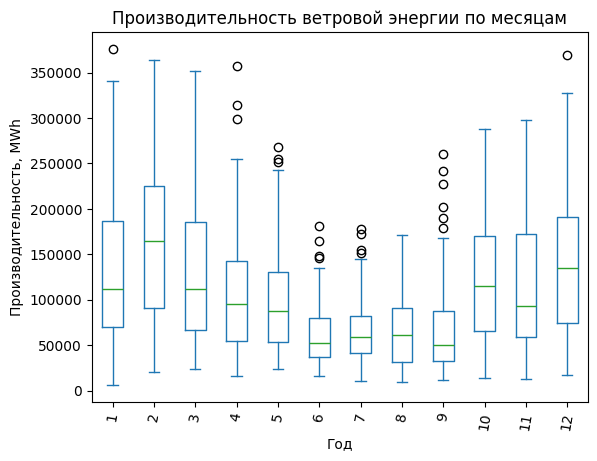

In [33]:
wind_data.plot.box(column="Production", by="Month")
plt.xticks(rotation=80)
plt.xlabel("Год")
plt.ylabel("Производительность, MWh")
plt.title("Производительность ветровой энергии по месяцам")

In [34]:
#wind_data.plot.box(column="Production", by="Month")
#plt.xticks(rotation=80)
#plt.xlabel("Год")
#plt.ylabel("Производительность, MWh")
#plt.title("Производительность солненой энергии по месяцам")

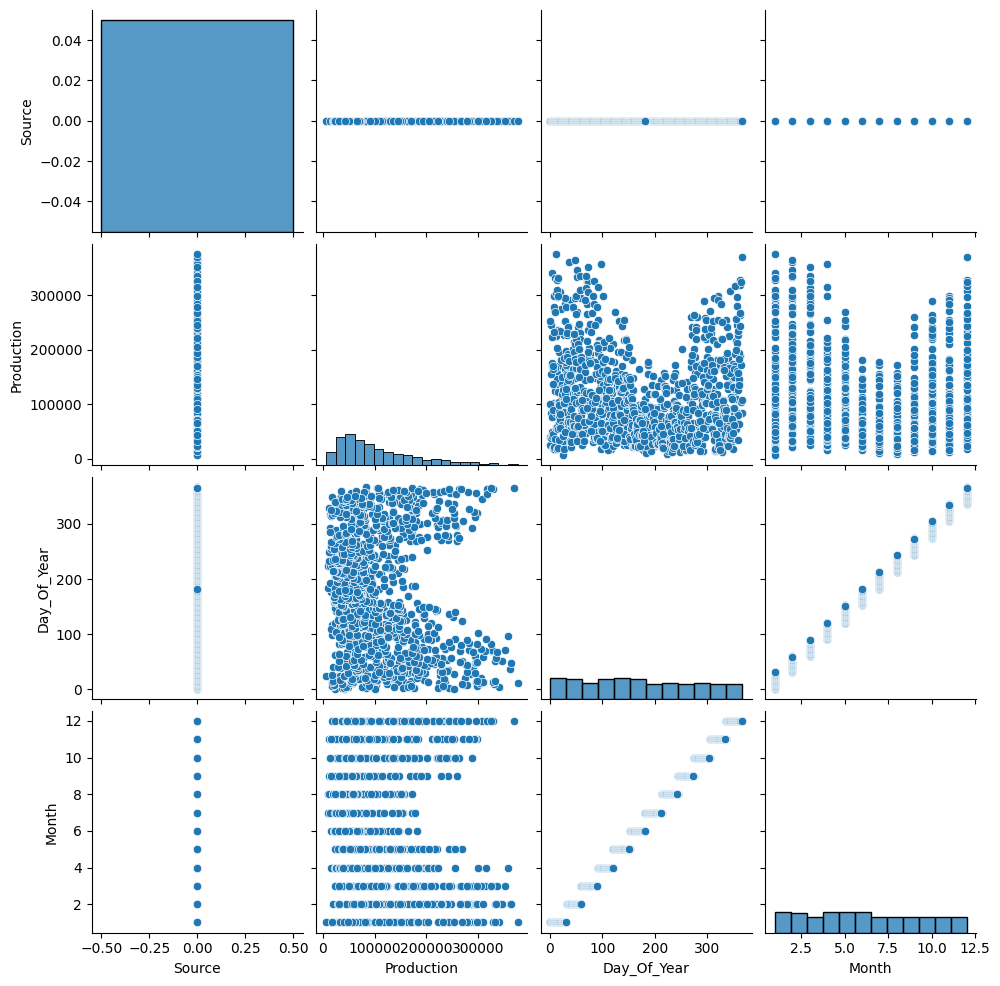

In [35]:
sns.pairplot(wind_data)

<Axes: >

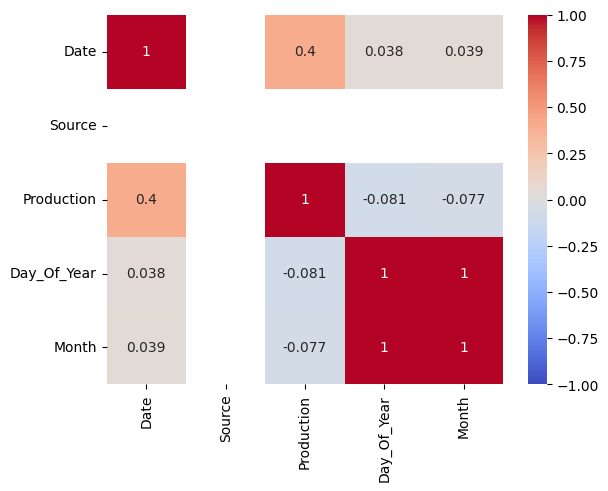

In [36]:
sns.heatmap(solar_data.corr(), vmax=1, vmin=-1, annot=True, cmap="coolwarm")

<Axes: >

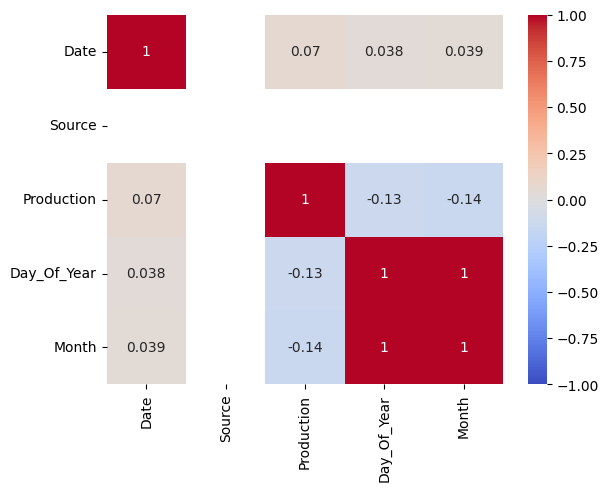

In [37]:
sns.heatmap(wind_data.corr(), vmax=1, vmin=-1, annot=True, cmap="coolwarm")

In [38]:
dayofyear_wind=wind_data.groupby(["Day_Of_Year","Month"])["Production"].agg(["sum", "count"]).reset_index()
dayofyear_wind


,Day_Of_Year,Month,sum,count
0,1,1,418094.0,4
1,2,1,520981.0,4
2,3,1,614132.0,4
3,4,1,636693.0,4
4,5,1,384549.0,4
...,...,...,...,...
370,362,12,908802.0,3
371,363,12,698942.0,3
372,364,12,600318.0,3
373,365,12,560958.0,3


In [39]:
#создаем столбец со среднй выботкой энергии по дню года
dayofyear_wind["Production_mean"]=dayofyear_wind["sum"]/dayofyear_wind["count"]
dayofyear_wind

,Day_Of_Year,Month,sum,count,Production_mean
0,1,1,418094.0,4,104523.500000
1,2,1,520981.0,4,130245.250000
2,3,1,614132.0,4,153533.000000
3,4,1,636693.0,4,159173.250000
4,5,1,384549.0,4,96137.250000
...,...,...,...,...,...
370,362,12,908802.0,3,302934.000000
371,363,12,698942.0,3,232980.666667
372,364,12,600318.0,3,200106.000000
373,365,12,560958.0,3,186986.000000


In [40]:
dayofyear_wind=dayofyear_wind.drop(["sum", "count"], axis=1)
dayofyear_wind

,Day_Of_Year,Month,Production_mean
0,1,1,104523.500000
1,2,1,130245.250000
2,3,1,153533.000000
3,4,1,159173.250000
4,5,1,96137.250000
...,...,...,...
370,362,12,302934.000000
371,363,12,232980.666667
372,364,12,200106.000000
373,365,12,186986.000000


In [41]:
dayofyear_solar

,Day_Of_Year,Month,Production_mean
0,1,1,9218.500000
1,2,1,6752.000000
2,3,1,8922.000000
3,4,1,7897.750000
4,5,1,10484.250000
...,...,...,...
370,362,12,7361.666667
371,363,12,6166.000000
372,364,12,8721.666667
373,365,12,11849.666667


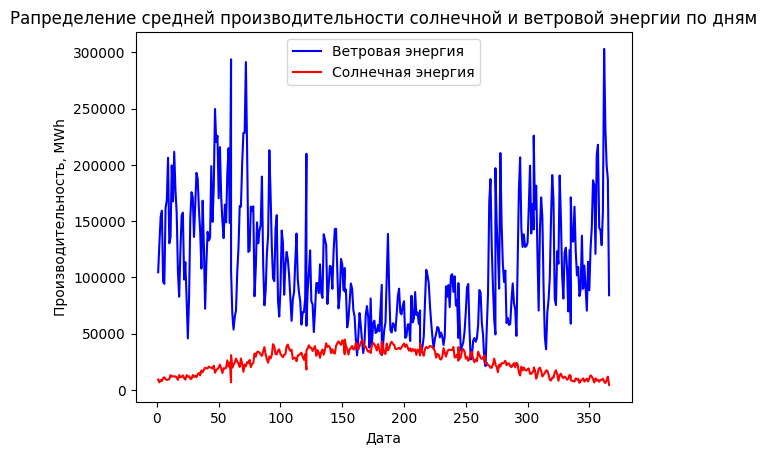

In [42]:
plt.figure
plt.plot(dayofyear_wind["Day_Of_Year"], dayofyear_wind["Production_mean"],color="blue", label="Ветровая энергия")
plt.plot(dayofyear_solar["Day_Of_Year"], dayofyear_solar["Production_mean"],color="red", label="Солнечная энергия")
plt.xlabel("Дата")
plt.ylabel("Производительность, MWh")
plt.title("Рапределение средней производительности солнечной и ветровой энергии по дням")
plt.legend()

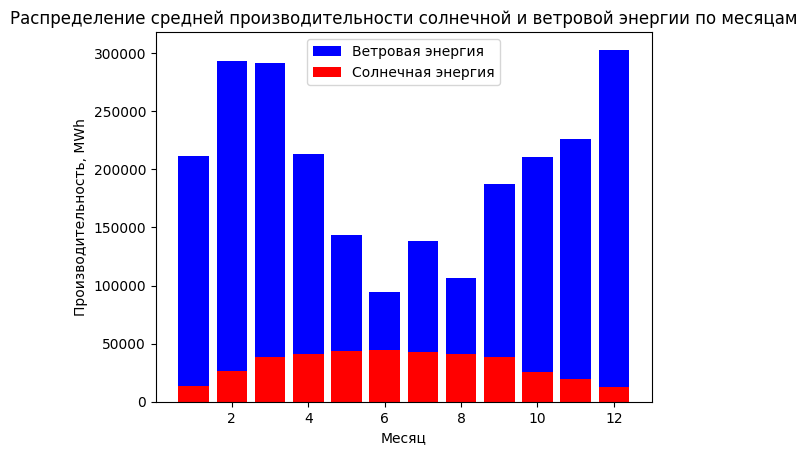

In [43]:
plt.figure
plt.bar(dayofyear_wind["Month"], dayofyear_wind["Production_mean"],color="blue", label="Ветровая энергия")
plt.bar(dayofyear_solar["Month"], dayofyear_solar["Production_mean"],color="red", label="Солнечная энергия")
plt.xlabel("Месяц")
plt.ylabel("Производительность, MWh")
plt.title("Раcпределение средней производительности солнечной и ветровой энергии по месяцам")
plt.legend()

<Axes: xlabel='Date', ylabel='Production'>

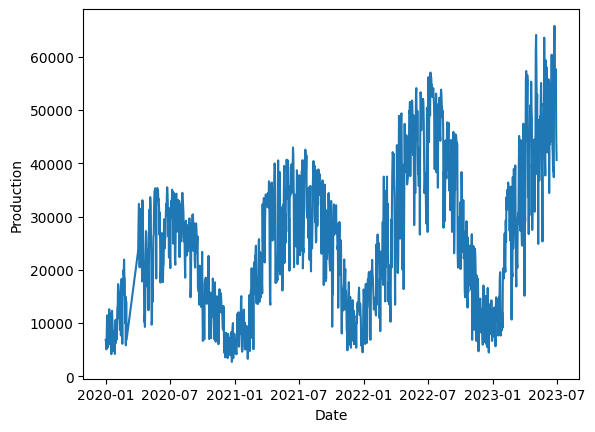

In [44]:
plt.figure
sns.lineplot(x=solar_data["Date"], y=solar_data["Production"])

<Axes: xlabel='Day_Of_Year', ylabel='Production_mean'>

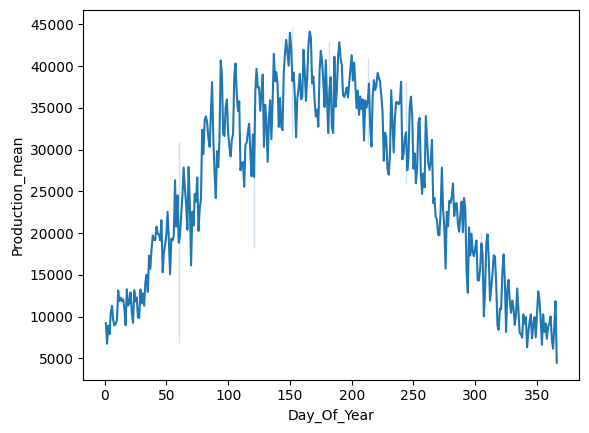

In [45]:
plt.figure
sns.lineplot(x=dayofyear_solar["Day_Of_Year"], y=dayofyear_solar["Production_mean"])

<Axes: xlabel='Date', ylabel='Production'>

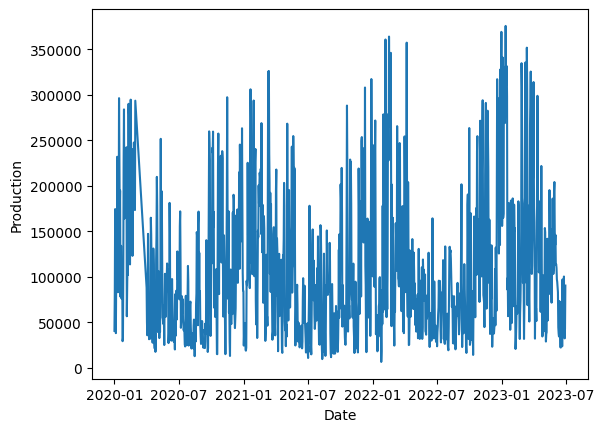

In [46]:
plt.figure
sns.lineplot(x=wind_data["Date"], y=wind_data["Production"])

<Axes: xlabel='Day_Of_Year', ylabel='Production_mean'>

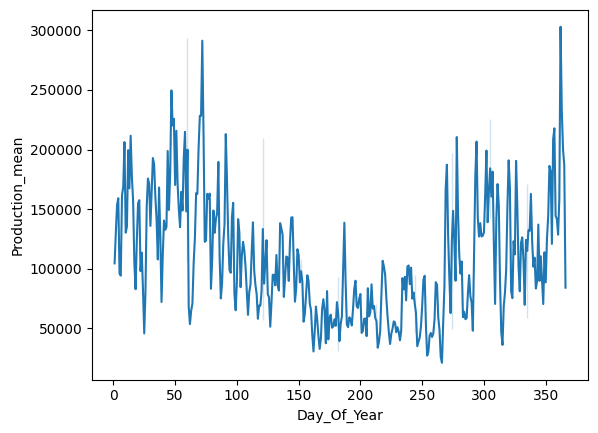

In [47]:
plt.figure
sns.lineplot(x=dayofyear_wind["Day_Of_Year"], y=dayofyear_wind["Production_mean"])

In [ ]:
ПРИСТУПАЕМ КПОСТРОЕНИЮ МОДЕЛЕЙ ЛИНЕЙНОЙ РЕГРЕССИИ

In [48]:
# создаю ,будущие даты на месяц вперед для предсказания
future_dates = pd.date_range(start="2023-07-01", end="2023-08-01", freq="D").to_series().reset_index(drop=True)

In [49]:
#создаю новый датафрейм х. С помощью конката соеденяю даты(ни года) из таблицы нашей группировки  с будущими датами
x=pd.DataFrame()
x["Day_Of_Year"] = pd.concat([dayofyear_solar["Day_Of_Year"],future_dates], axis=0)
x=x.reset_index(drop=True)
x

,Day_Of_Year
0,1
1,2
2,3
3,4
4,5
...,...
402,2023-07-28 00:00:00
403,2023-07-29 00:00:00
404,2023-07-30 00:00:00
405,2023-07-31 00:00:00


In [50]:
#создаю столбец месяц
x["Month"]=dayofyear_solar["Month"] 
x

,Day_Of_Year,Month
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
402,2023-07-28 00:00:00,NaN
403,2023-07-29 00:00:00,NaN
404,2023-07-30 00:00:00,NaN
405,2023-07-31 00:00:00,NaN


In [51]:
#создаю столбец с месяцем
#в столбцесяца nan заменяю на 7 (преказываем июль)
x["Month"] = x["Month"]. fillna (7)
x

,Day_Of_Year,Month
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
402,2023-07-28 00:00:00,7.0
403,2023-07-29 00:00:00,7.0
404,2023-07-30 00:00:00,7.0
405,2023-07-31 00:00:00,7.0


In [52]:
#Cоздаю цифры в диапозоне от 0 до конца строки. То же самое, что индексы вынести в отд столбец. Мы это делаем, так как время
#это просто идеология, и можно использовать цифры
#делаем несколько трендов, так как у нас много изгибов на графике, явно присутствует квадратичная зависимость
x["trend1"]=range(0, len(x))
x["trend2"]=x["trend1"]**2
x["trend3"]=x["trend1"]**3
 

In [53]:
# используем даммис. И переименовываем с помощью цикла столбцы.
month_tmp=pd.get_dummies(x["Month"])*1
clms=[]
for i in month_tmp.columns:
    clms.append("Month_"+str(i))

month_tmp.columns=clms
month_tmp

,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
402,0,0,0,0,0,0,1,0,0,0,0,0
403,0,0,0,0,0,0,1,0,0,0,0,0
404,0,0,0,0,0,0,1,0,0,0,0,0
405,0,0,0,0,0,0,1,0,0,0,0,0


In [54]:
#так как у нас временные ряды и мы делали даммис, мы удаляем один любой столбец. И сшиваем х и tmp с помощью concat
month_tmp=month_tmp.drop("Month_5.0", axis=1)
x=pd.concat([x,month_tmp],axis=1)
x

,Day_Of_Year,Month,trend1,trend2,trend3,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,3,1.0,2,4,8,1,0,0,0,0,0,0,0,0,0,0
3,4,1.0,3,9,27,1,0,0,0,0,0,0,0,0,0,0
4,5,1.0,4,16,64,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2023-07-28 00:00:00,7.0,402,161604,64964808,0,0,0,0,0,1,0,0,0,0,0
403,2023-07-29 00:00:00,7.0,403,162409,65450827,0,0,0,0,0,1,0,0,0,0,0
404,2023-07-30 00:00:00,7.0,404,163216,65939264,0,0,0,0,0,1,0,0,0,0,0
405,2023-07-31 00:00:00,7.0,405,164025,66430125,0,0,0,0,0,1,0,0,0,0,0


In [55]:
#удаляемлишние столбцы
x=x.drop(["Day_Of_Year", "Month"], axis=1)
x

,trend1,trend2,trend3,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,2,4,8,1,0,0,0,0,0,0,0,0,0,0
3,3,9,27,1,0,0,0,0,0,0,0,0,0,0
4,4,16,64,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,161604,64964808,0,0,0,0,0,1,0,0,0,0,0
403,403,162409,65450827,0,0,0,0,0,1,0,0,0,0,0
404,404,163216,65939264,0,0,0,0,0,1,0,0,0,0,0
405,405,164025,66430125,0,0,0,0,0,1,0,0,0,0,0


In [56]:
x_fact=x.iloc[0:len(x)-32]
x_future=x[len(x)-32:]

y_fact=dayofyear_solar["Production_mean"]

In [57]:
#Далее ум линейную регрессию
ln=LinearRegression()
ln.fit(x_fact, y_fact)

LinearRegression()

In [58]:
#смотрим точность предсказания
ln.score(x_fact, y_fact)

0.8983008806644879

In [59]:
#создаем массив , и далее я смогу нарисовать график
ln.predict(x_future)

array([7952.56709305, 7831.29217559, 7711.29506302, 7592.58849717,
       7475.18521988, 7359.09797296, 7244.33949825, 7130.92253757,
       7018.85983276, 6908.16412563, 6798.84815803, 6690.92467177,
       6584.40640869, 6479.30611061, 6375.63651936, 6273.41037677,
       6172.64042467, 6073.33940488, 5975.52005924, 5879.19512956,
       5784.37735769, 5691.07948544, 5599.31425465, 5509.09440714,
       5420.43268475, 5333.34182929, 5247.8345826 , 5163.92368651,
       5081.62188284, 5000.94191342, 4921.89652008, 4844.49844465])

<Axes: xlabel='trend1'>

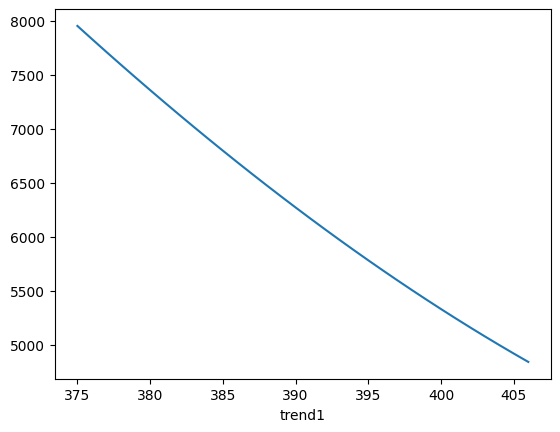

In [60]:
plt.figure
sns.lineplot(x=x_future["trend1"], y=ln.predict(x_future))

In [61]:
# создаю ,будущие даты на месяц вперед для предсказания
future_dates = pd.date_range(start="2023-07-01", end="2023-08-01", freq="D").to_series().reset_index(drop=True)

In [62]:
#создаю новый датафрейм х. С помощью конката соеденяю даты из таблицы с будущими датами
x=pd.DataFrame()
x["Day_Of_Year"] = pd.concat([dayofyear_wind["Day_Of_Year"],future_dates], axis=0)
x=x.reset_index(drop=True)
x

,Day_Of_Year
0,1
1,2
2,3
3,4
4,5
...,...
402,2023-07-28 00:00:00
403,2023-07-29 00:00:00
404,2023-07-30 00:00:00
405,2023-07-31 00:00:00


In [63]:
#создаю столбец день недели
x["Month"]=dayofyear_wind["Month"] 
x

,Day_Of_Year,Month
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
402,2023-07-28 00:00:00,NaN
403,2023-07-29 00:00:00,NaN
404,2023-07-30 00:00:00,NaN
405,2023-07-31 00:00:00,NaN


In [64]:
x["Month"] = x["Month"]. fillna (7)
x

,Day_Of_Year,Month
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
...,...,...
402,2023-07-28 00:00:00,7.0
403,2023-07-29 00:00:00,7.0
404,2023-07-30 00:00:00,7.0
405,2023-07-31 00:00:00,7.0


In [65]:
#Cоздаю цифры в диапозоне от 0 до конца строй х. Мы это делаем, так как время
# просто идеология, и моно использовать цифры
#делаем несколько трендв, так как у нас много изгибов на графике. Мож попробвть сделать больше
x["trend1"]=range(0, len(x))
x["trend2"]=x["trend1"]**2
x["trend3"]=x["trend1"]**3

In [66]:
#Используем даммис.И переименовываем с помощью цикла столбцы.
month_tmp=pd.get_dummies(x["Month"])*1
clms=[]
for i in month_tmp.columns:
    clms.append("Month_"+str(i))

month_tmp.columns=clms
month_tmp

,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_5.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
402,0,0,0,0,0,0,1,0,0,0,0,0
403,0,0,0,0,0,0,1,0,0,0,0,0
404,0,0,0,0,0,0,1,0,0,0,0,0
405,0,0,0,0,0,0,1,0,0,0,0,0


In [67]:
#так как у нас временные ряды и мы делали даммис, мы удаляем дин любой столбец. И сшиваем х и tmp с помощью concat
month_tmp=month_tmp.drop("Month_5.0", axis=1)
x=pd.concat([x,month_tmp],axis=1)
x

,Day_Of_Year,Month,trend1,trend2,trend3,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,3,1.0,2,4,8,1,0,0,0,0,0,0,0,0,0,0
3,4,1.0,3,9,27,1,0,0,0,0,0,0,0,0,0,0
4,5,1.0,4,16,64,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2023-07-28 00:00:00,7.0,402,161604,64964808,0,0,0,0,0,1,0,0,0,0,0
403,2023-07-29 00:00:00,7.0,403,162409,65450827,0,0,0,0,0,1,0,0,0,0,0
404,2023-07-30 00:00:00,7.0,404,163216,65939264,0,0,0,0,0,1,0,0,0,0,0
405,2023-07-31 00:00:00,7.0,405,164025,66430125,0,0,0,0,0,1,0,0,0,0,0


In [68]:
#удаляемлишние столбцы
x=x.drop(["Day_Of_Year", "Month"], axis=1)
x

,trend1,trend2,trend3,Month_1.0,Month_2.0,Month_3.0,Month_4.0,Month_6.0,Month_7.0,Month_8.0,Month_9.0,Month_10.0,Month_11.0,Month_12.0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
2,2,4,8,1,0,0,0,0,0,0,0,0,0,0
3,3,9,27,1,0,0,0,0,0,0,0,0,0,0
4,4,16,64,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,161604,64964808,0,0,0,0,0,1,0,0,0,0,0
403,403,162409,65450827,0,0,0,0,0,1,0,0,0,0,0
404,404,163216,65939264,0,0,0,0,0,1,0,0,0,0,0
405,405,164025,66430125,0,0,0,0,0,1,0,0,0,0,0


In [69]:

x_fact=x.iloc[0:len(x)-32]
x_future=x[len(x)-32:]

y_fact=dayofyear_wind["Production_mean"]

In [70]:
#Далее ум линейную регрессию
ln=LinearRegression()
ln.fit(x_fact, y_fact)

LinearRegression()

In [71]:
#смотрим точность предсказания
ln.score(x_fact, y_fact)

0.451334085426489

In [72]:
#создаем массив , и далее я смогу нарисовать график
ln.predict(x_future)

array([200874.25087418, 202590.12237971, 204320.27381652, 206064.76490533,
       207823.65536686, 209597.00492183, 211384.87329094, 213187.32019492,
       215004.40535449, 216836.18849036, 218682.72932324, 220544.08757386,
       222420.32296294, 224311.49521118, 226217.66403931, 228138.88916804,
       230075.23031809, 232026.74721018, 233993.49956502, 235975.54710333,
       237972.94954583, 239985.76661323, 242014.05802625, 244057.88350561,
       246117.30277203, 248192.37554621, 250283.16154889, 252389.72050077,
       254512.11212257, 256650.39613501, 258804.63225881, 260974.88021468])

<Axes: xlabel='trend1'>

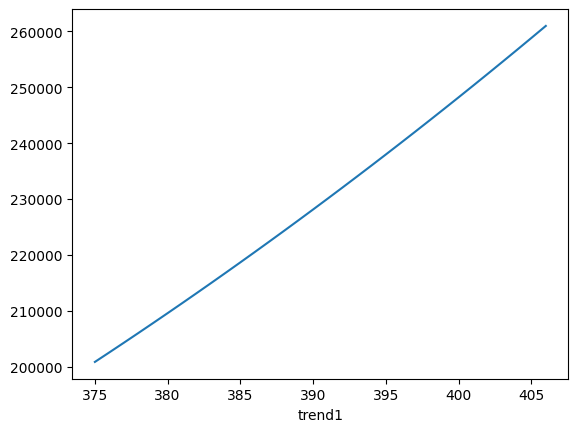

In [73]:
plt.figure
sns.lineplot(x=x_future["trend1"], y=ln.predict(x_future))

In [145]:
wind_data

,Date,Source,Production,Day_Of_Year,Month
0,2020-01-01,0,40432.0,1,1
1,2020-01-02,0,82888.0,2,1
2,2020-01-03,0,174389.0,3,1
3,2020-01-04,0,76686.0,4,1
4,2020-01-05,0,37920.0,5,1
...,...,...,...,...,...
1241,2023-06-26,0,100225.0,177,6
1242,2023-06-27,0,49822.0,178,6
1243,2023-06-28,0,32186.0,179,6
1244,2023-06-29,0,43038.0,180,6


<Axes: >

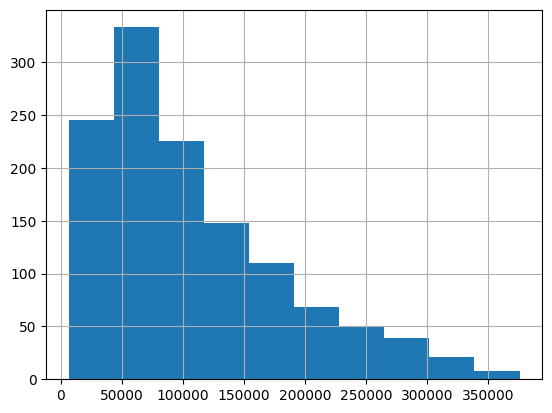

In [146]:
wind_data['Production'].hist()

In [147]:
# Сколько дней в исходных данных
fact_len = len(wind_data)
fact_len

1246

In [148]:
# создаю удущиедаты на месяц вперед для предсказания
future_dates = pd.date_range(start="2023-07-01", end="2023-08-01", freq="D").to_series().reset_index(drop=True)
future_len = len(future_dates)
future_len

32

In [149]:
#создаю новый датафрейм х. С помощью конката соеденяю даты из таблицы с будущими датами
X=pd.DataFrame()
X["Date"] = pd.concat([wind_data["Date"],future_dates], axis=0)
X=X.reset_index(drop=True)
X

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
1273,2023-07-28
1274,2023-07-29
1275,2023-07-30
1276,2023-07-31


In [150]:
X['Month'] = X['Date'].dt.month
X['Day_Of_Year'] = X['Date'].dt.dayofyear
X["trend"]=range(0, len(X))
X["trend2"]=X["trend"]**2
X["trend3"]=X["trend"]**3


X

,Date,Month,Day_Of_Year,trend,trend2,trend3
0,2020-01-01,1,1,0,0,0
1,2020-01-02,1,2,1,1,1
2,2020-01-03,1,3,2,4,8
3,2020-01-04,1,4,3,9,27
4,2020-01-05,1,5,4,16,64
...,...,...,...,...,...,...
1273,2023-07-28,7,209,1273,1620529,2062933417
1274,2023-07-29,7,210,1274,1623076,2067798824
1275,2023-07-30,7,211,1275,1625625,2072671875
1276,2023-07-31,7,212,1276,1628176,2077552576


In [151]:
month_tmp = pd.get_dummies(X['Month'])*1
month_tmp = month_tmp.drop(2, axis=1)
new_columns = []
for el in month_tmp.columns:
    el = str(el) + "_Month"
    new_columns.append(el)
month_tmp.columns = new_columns

In [152]:
month_tmp

,1_Month,3_Month,4_Month,5_Month,6_Month,7_Month,8_Month,9_Month,10_Month,11_Month,12_Month
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1273,0,0,0,0,0,1,0,0,0,0,0
1274,0,0,0,0,0,1,0,0,0,0,0
1275,0,0,0,0,0,1,0,0,0,0,0
1276,0,0,0,0,0,1,0,0,0,0,0


In [153]:
day_tmp = pd.get_dummies(X['Day_Of_Year'])*1
day_tmp = day_tmp.drop(2, axis=1)
new_columns = []
for el in day_tmp.columns:
    el = str(el) + "_Day_Of_Year"
    new_columns.append(el)
day_tmp.columns = new_columns

In [154]:
X = pd.concat([X, month_tmp,day_tmp], axis=1)

In [155]:
X

,Date,Month,Day_Of_Year,trend,trend2,trend3,1_Month,3_Month,4_Month,5_Month,...,357_Day_Of_Year,358_Day_Of_Year,359_Day_Of_Year,360_Day_Of_Year,361_Day_Of_Year,362_Day_Of_Year,363_Day_Of_Year,364_Day_Of_Year,365_Day_Of_Year,366_Day_Of_Year
0,2020-01-01,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-02,1,2,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-03,1,3,2,4,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-04,1,4,3,9,27,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-05,1,5,4,16,64,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,2023-07-28,7,209,1273,1620529,2062933417,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1274,2023-07-29,7,210,1274,1623076,2067798824,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1275,2023-07-30,7,211,1275,1625625,2072671875,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1276,2023-07-31,7,212,1276,1628176,2077552576,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [156]:
X = X.drop(['Date', 'Month','Day_Of_Year'], axis=1)

In [157]:
X.shape

(1278, 379)

In [158]:
# Я оставлю 1 месяц на тестирование. 31 день с конца датасета

train_len = fact_len - 31
train_len

1215

In [159]:
X_train = X.iloc[0:train_len,]
Y_train = wind_data['Production'].iloc[0:train_len]
X_test = X.iloc[train_len:fact_len,]
Y_test = wind_data.loc[train_len:fact_len,'Production']

Y_train = np.log(Y_train)
Y_test = np.log(Y_test)

X_with_future = X # вся длина ряда для прогнозирования

In [160]:
print(len(X_train), len(Y_train))

print(len(X_test), len(Y_test))

1215 1215
31 31


In [161]:
model_reg_time = RandomForestRegressor(n_estimators=100, # количество деревьев
                              criterion='squared_error', # функция измерения чистоты классов в нодах
                              max_depth=20, # максимальная глубина дерева
                              #min_samples_split=10, # минимальное число наблюдений в родительской ноде (перед делением)
                              min_samples_leaf=1, # минимальное число наблюдений в конечной ноде
                              #max_features='sqrt', # число столбцов для каждого дерева
                              bootstrap=True, # делать ли подвыборки строк для деревьев. Или учить каждое дерево на всех строках
                              max_samples=65,
                              random_state=45,
                              verbose=0 #выводить ли промежуточные состояния во время обучения
                              )
model_reg_time.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, max_samples=65, random_state=45)

In [162]:
Y_model_train = model_reg_time.predict(X_train)
Y_model_train = np.exp(Y_model_train)
Y_model_test = model_reg_time.predict(X_test)
Y_model_test = np.exp(Y_model_test)

In [163]:
print(mean_absolute_error(np.exp(Y_train), Y_model_train))
print(mean_absolute_error(np.exp(Y_test), Y_model_test))

50007.08520087253
31143.748835278824


In [164]:
#Среднняя квадратичная ошибка 31, для данных  от 87 464 100 743 ошибка составляет примерно 25-30%. Этирезультаты намного лучше чем при построении модели
#регрессии для временных рядов.

In [165]:
Y_future = model_reg_time.predict(X_with_future)
Y_future = np.exp(Y_future)

In [166]:
print(model_reg_time.score(X_train,Y_train))
print(model_reg_time.score(X_test,Y_test))

0.27274533770102405
-0.19607971269472912


In [167]:
## Прогнозные значения на месяц
Y_future[fact_len:]

array([ 97857.47502303,  89958.75348183,  99767.56973944,  99806.16318061,
       100743.43498914, 100363.8712055 ,  99806.16318061, 100007.53235709,
        95982.64808866,  98742.38759219,  96774.39195361,  99806.16318061,
        98071.750684  ,  99489.30786136, 100637.05194892,  99806.16318061,
        99806.16318061, 100154.22082622,  97933.99912802, 100425.39705536,
       100119.26015745, 100263.09394966,  96334.46994737,  96763.04119798,
       100358.49982844,  97770.8068904 ,  99806.16318061,  99731.77764549,
        97486.81015388,  97999.3121174 ,  99806.16318061,  87464.28367436])

In [168]:
main_data_for_plot = pd.DataFrame()

main_data_for_plot['Date'] = pd.concat([wind_data['Date'], 
                                   future_dates], 
                                   axis=0).reset_index(drop=True)

main_data_for_plot['Fact'] = pd.concat([wind_data['Production'], 
                                   pd.Series(list(repeat(np.nan, future_len)))], 
                                   axis=0).reset_index(drop=True) # фактические значения + хвостик из пропусков

main_data_for_plot['Model'] = pd.concat([pd.Series(Y_model_train), 
                                    pd.Series(Y_model_test), 
                                    pd.Series(list(repeat(np.nan, future_len)))], 
                                    axis=0, ignore_index=True).reset_index(drop=True)

main_data_for_plot['Prediction'] = pd.concat([pd.Series(list(repeat(np.nan, fact_len))),
                                         pd.Series(Y_future[fact_len:])], 
                                         axis=0, ignore_index=True).reset_index(drop=True) 

In [169]:
main_data_for_plot = main_data_for_plot.set_index('Date')
main_data_for_plot

,Fact,Model,Prediction
Date,,,
2020-01-01,40432.0,118231.757394,NaN
2020-01-02,82888.0,121768.301133,NaN
2020-01-03,174389.0,119754.863600,NaN
2020-01-04,76686.0,124550.027037,NaN
2020-01-05,37920.0,119513.767660,NaN
...,...,...,...
2023-07-28,NaN,NaN,99731.777645
2023-07-29,NaN,NaN,97486.810154
2023-07-30,NaN,NaN,97999.312117


<Axes: xlabel='Date'>

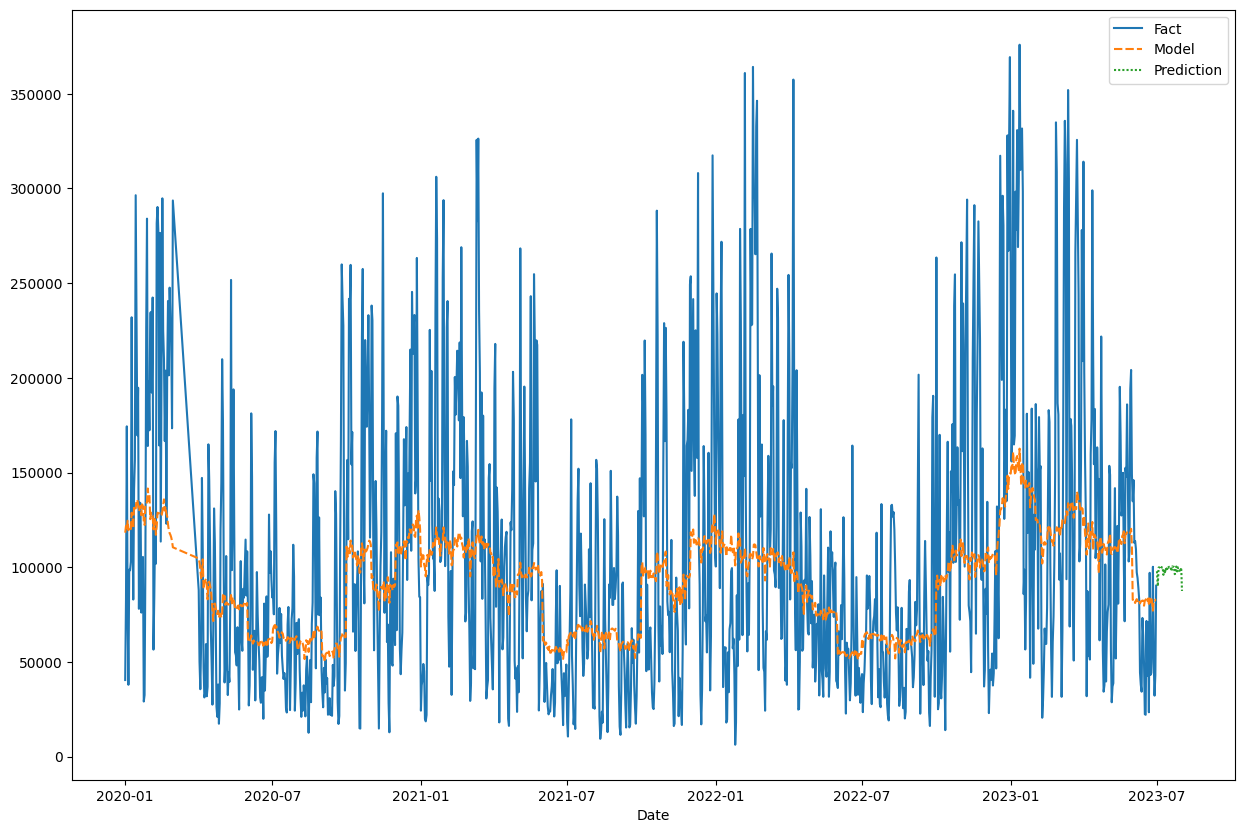

In [170]:
plt.figure(figsize=(15,10))
sns.lineplot(main_data_for_plot)

In [121]:
solar_data

,Date,Source,Production,Day_Of_Year,Month
0,2020-01-01,1,6821.0,1,1
1,2020-01-02,1,6349.0,2,1
2,2020-01-03,1,5036.0,3,1
3,2020-01-04,1,7957.0,4,1
4,2020-01-05,1,11438.0,5,1
...,...,...,...,...,...
1241,2023-06-26,1,54698.0,177,6
1242,2023-06-27,1,56356.0,178,6
1243,2023-06-28,1,57698.0,179,6
1244,2023-06-29,1,44728.0,180,6


<Axes: >

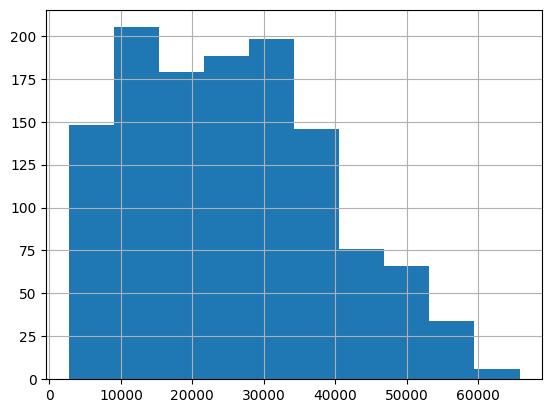

In [122]:
 
solar_data['Production'].hist()

In [123]:
# Сколько дней в исходных данных
fact_len = len(solar_data)
fact_len

1246

In [124]:
# создаю удущиедаты на месяц вперед для предсказания
future_dates = pd.date_range(start="2023-07-01", end="2023-08-01", freq="D").to_series().reset_index(drop=True)
future_len = len(future_dates)
future_len

32

In [125]:
#создаю новый датафрейм х. С помощью конката соеденяю даты из таблицы с будущими датами
X=pd.DataFrame()
X["Date"] = pd.concat([solar_data["Date"],future_dates], axis=0)
X=X.reset_index(drop=True)
X

,Date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
1273,2023-07-28
1274,2023-07-29
1275,2023-07-30
1276,2023-07-31


In [126]:
X['Month'] = X['Date'].dt.month
X['Day_Of_Year'] = X['Date'].dt.dayofyear
X["trend"]=range(0, len(X))
X["trend2"]=X["trend"]**2
X["trend3"]=X["trend"]**3

X

,Date,Month,Day_Of_Year,trend,trend2,trend3
0,2020-01-01,1,1,0,0,0
1,2020-01-02,1,2,1,1,1
2,2020-01-03,1,3,2,4,8
3,2020-01-04,1,4,3,9,27
4,2020-01-05,1,5,4,16,64
...,...,...,...,...,...,...
1273,2023-07-28,7,209,1273,1620529,2062933417
1274,2023-07-29,7,210,1274,1623076,2067798824
1275,2023-07-30,7,211,1275,1625625,2072671875
1276,2023-07-31,7,212,1276,1628176,2077552576


In [127]:
month_tmp = pd.get_dummies(X['Month'])*1
month_tmp = month_tmp.drop(2, axis=1)
new_columns = []
for el in month_tmp.columns:
    el = str(el) + "_Month"
    new_columns.append(el)
month_tmp.columns = new_columns

In [128]:
month_tmp

,1_Month,3_Month,4_Month,5_Month,6_Month,7_Month,8_Month,9_Month,10_Month,11_Month,12_Month
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1273,0,0,0,0,0,1,0,0,0,0,0
1274,0,0,0,0,0,1,0,0,0,0,0
1275,0,0,0,0,0,1,0,0,0,0,0
1276,0,0,0,0,0,1,0,0,0,0,0


In [129]:
day_tmp = pd.get_dummies(X['Day_Of_Year'])*1
day_tmp = day_tmp.drop(2, axis=1)
new_columns = []
for el in day_tmp.columns:
    el = str(el) + "_Day_Of_Year"
    new_columns.append(el)
day_tmp.columns = new_columns

In [130]:
X = pd.concat([X, month_tmp,day_tmp], axis=1)

In [131]:
X = X.drop(['Date', 'Month','Day_Of_Year'], axis=1)

In [132]:
X

,trend,trend2,trend3,1_Month,3_Month,4_Month,5_Month,6_Month,7_Month,8_Month,...,357_Day_Of_Year,358_Day_Of_Year,359_Day_Of_Year,360_Day_Of_Year,361_Day_Of_Year,362_Day_Of_Year,363_Day_Of_Year,364_Day_Of_Year,365_Day_Of_Year,366_Day_Of_Year
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,9,27,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,16,64,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,1273,1620529,2062933417,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1274,1274,1623076,2067798824,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1275,1275,1625625,2072671875,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1276,1276,1628176,2077552576,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
X_train = X.iloc[0:train_len,]
Y_train = solar_data['Production'].iloc[0:train_len]
X_test = X.iloc[train_len:fact_len,]
Y_test = solar_data.loc[train_len:fact_len,'Production']

Y_train = np.log(Y_train)
Y_test = np.log(Y_test)

X_with_future = X # вся длина ряда для прогнозирования

In [134]:
print(len(X_train), len(Y_train))

print(len(X_test), len(Y_test))

1215 1215
31 31


In [135]:
model_reg_time = RandomForestRegressor(n_estimators=100, # количество деревьев
                              criterion='squared_error', # функция измерения чистоты классов в нодах
                              max_depth=20, # максимальная глубина дерева
                              #min_samples_split=10, # минимальное число наблюдений в родительской ноде (перед делением)
                              min_samples_leaf=1, # минимальное число наблюдений в конечной ноде
                              #max_features='sqrt', # число столбцов для каждого дерева
                              bootstrap=True, # делать ли подвыборки строк для деревьев. Или учить каждое дерево на всех строках
                              max_samples=65,
                              random_state=45,
                              verbose=0 #выводить ли промежуточные состояния во время обучения
                              )
model_reg_time.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, max_samples=65, random_state=45)

In [136]:
Y_model_train = model_reg_time.predict(X_train)
Y_model_train = np.exp(Y_model_train)
Y_model_test = model_reg_time.predict(X_test)
Y_model_test = np.exp(Y_model_test)

In [137]:
print(mean_absolute_error(np.exp(Y_train), Y_model_train))
print(mean_absolute_error(np.exp(Y_test), Y_model_test))

5013.626449510657
8871.358085923068


In [138]:
Y_future = model_reg_time.predict(X_with_future)
Y_future = np.exp(Y_future)

In [140]:
print(model_reg_time.score(X_train,Y_train))
print(model_reg_time.score(X_test,Y_test))

0.7493394138234408
-0.792465197766951


In [141]:
## Прогнозные значения на месяц
Y_future[fact_len:]

array([43599.43923133, 43599.43923133, 43703.39444962, 43599.43923133,
       43577.54187982, 43599.43923133, 43599.43923133, 43599.43923133,
       43755.61379259, 43599.43923133, 43631.15586105, 43346.45552969,
       43599.43923133, 43599.43923133, 43720.94694762, 43734.01427116,
       43599.43923133, 43599.43923133, 43542.78644068, 43599.43923133,
       43599.43923133, 43589.83139263, 43599.43923133, 43599.43923133,
       43599.43923133, 43599.43923133, 43599.43923133, 43599.43923133,
       43599.43923133, 43599.43923133, 44015.66401414, 42502.39158033])

In [142]:
main_data_for_plot = pd.DataFrame()

main_data_for_plot['Date'] = pd.concat([solar_data['Date'], 
                                   future_dates], 
                                   axis=0).reset_index(drop=True)

main_data_for_plot['Fact'] = pd.concat([solar_data['Production'], 
                                   pd.Series(list(repeat(np.nan, future_len)))], 
                                   axis=0).reset_index(drop=True) # фактические значения + хвостик из пропусков

main_data_for_plot['Model'] = pd.concat([pd.Series(Y_model_train), 
                                    pd.Series(Y_model_test), 
                                    pd.Series(list(repeat(np.nan, future_len)))], 
                                    axis=0, ignore_index=True).reset_index(drop=True)

main_data_for_plot['Prediction'] = pd.concat([pd.Series(list(repeat(np.nan, fact_len))),
                                         pd.Series(Y_future[fact_len:])], 
                                         axis=0, ignore_index=True).reset_index(drop=True) 

In [143]:
main_data_for_plot = main_data_for_plot.set_index('Date')
main_data_for_plot

,Fact,Model,Prediction
Date,,,
2020-01-01,6821.0,8533.009882,NaN
2020-01-02,6349.0,8613.464915,NaN
2020-01-03,5036.0,8584.518641,NaN
2020-01-04,7957.0,8449.790831,NaN
2020-01-05,11438.0,8643.729880,NaN
...,...,...,...
2023-07-28,NaN,NaN,43599.439231
2023-07-29,NaN,NaN,43599.439231
2023-07-30,NaN,NaN,43599.439231


<Axes: xlabel='Date'>

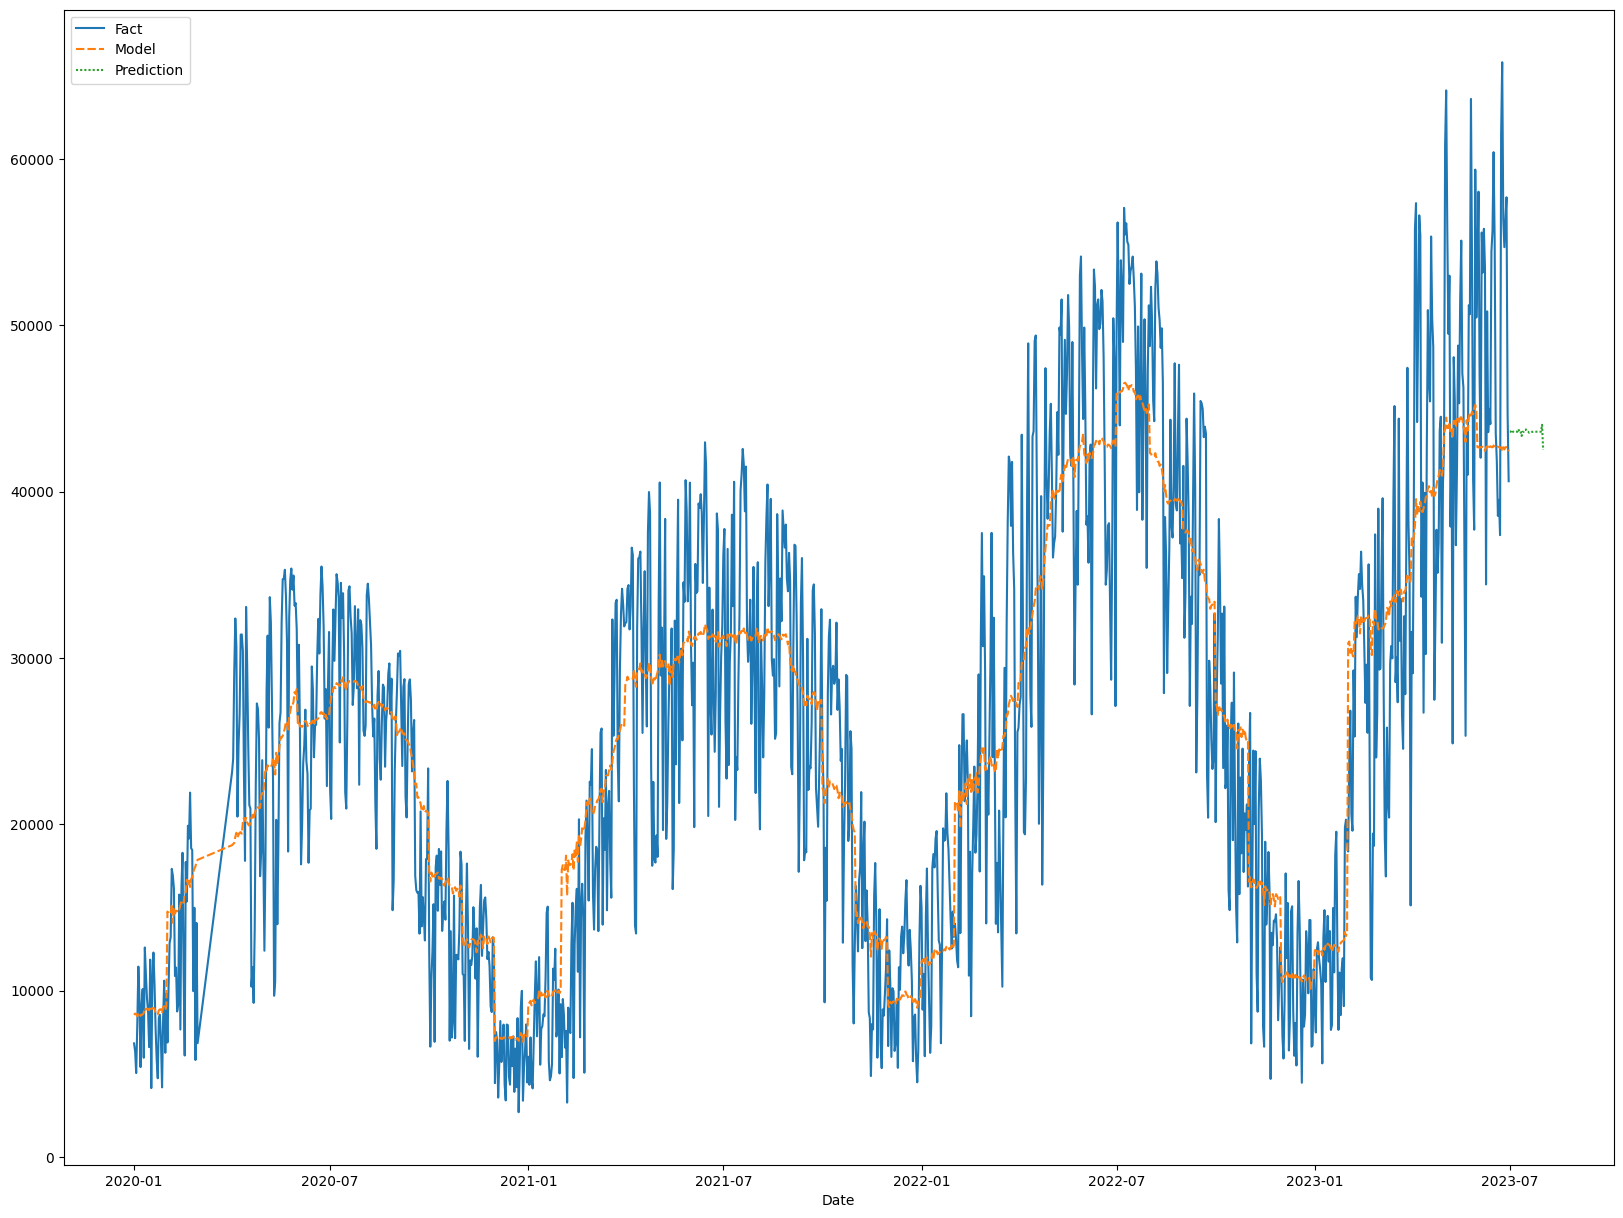

In [144]:
plt.figure(figsize=(20,15))
sns.lineplot(main_data_for_plot)